<a href="https://colab.research.google.com/github/mgraves236/neural-networks/blob/main/Sieci_neuronowe_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekt ten ma na celu stworzenie architektury sieci neuronowej oraz wytrenowanie jej wraz z doborem hiperparametrów tak, aby osiągnąć możliwie największe wartości wskazanych metryk.

Wykorzystywany dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10/data

26 191 elementów

In [54]:
# Potrzebne biblioteki

import pathlib
import PIL.Image as Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras

from keras.models import Sequential
import time

import tensorflow as tf

# 1. Pobranie danych

In [55]:
# Usuwanie istniejących folderów

!rm -rf sample_data

# Pobranie danych i wyodrębnienie ich

!wget https://www.dropbox.com/scl/fi/umlj0h521cc9rzeht1qyc/Animals.zip?rlkey=fsdj4wxjov41er8a08md0o6pi&dl=0
!unzip /content/Animals.zip?rlkey=fsdj4wxjov41er8a08md0o6pi

--2023-11-11 14:21:28--  https://www.dropbox.com/scl/fi/umlj0h521cc9rzeht1qyc/Animals.zip?rlkey=fsdj4wxjov41er8a08md0o6pi
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc28276416cae6019af7e427122a.dl.dropboxusercontent.com/cd/0/inline/CHXxU68-7fn6nPOZG5yU5CXLuXGRSgAD_FV6u9jKG9n8rLuMN1HF_4V0lHsEX-QdvnAx0ntQmKqNMmtr8KzEEX0qPyCPVE6v9QsYOzQetq1wn5IvJFPjoJebQnwzrDpLCyh29JiIVAnBhxUVixwz6SW_/file# [following]
--2023-11-11 14:21:28--  https://uc28276416cae6019af7e427122a.dl.dropboxusercontent.com/cd/0/inline/CHXxU68-7fn6nPOZG5yU5CXLuXGRSgAD_FV6u9jKG9n8rLuMN1HF_4V0lHsEX-QdvnAx0ntQmKqNMmtr8KzEEX0qPyCPVE6v9QsYOzQetq1wn5IvJFPjoJebQnwzrDpLCyh29JiIVAnBhxUVixwz6SW_/file
Resolving uc28276416cae6019af7e427122a.dl.dropboxusercontent.com (uc28276416cae6019af7e427122a.dl.dropboxusercontent.com)... 162.125.5.15, 2620:10

# 2. Przygotowanie danych

In [56]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/content/Animals/images"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('dog', 4863), ('spider', 4821), ('horse', 2623), ('cow', 1866), ('cat', 1668), ('squirrel', 1862), ('sheep', 1820), ('elephant', 1446), ('chicken', 3098), ('butterfly', 2112)])

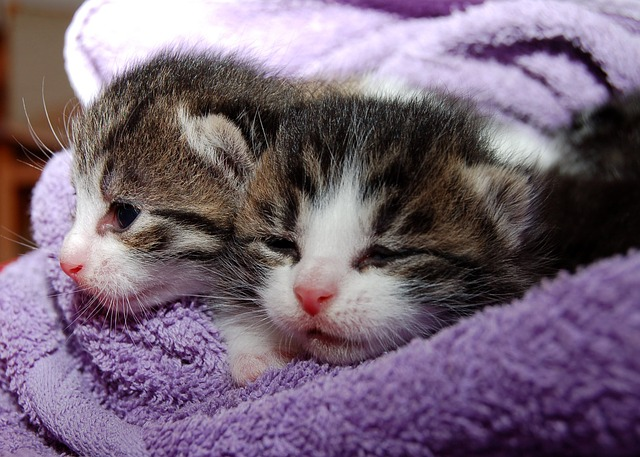

In [57]:
# Wyświetlenie przykładowego obrazu

data_dir='/content/Animals/images'
path_dir=pathlib.Path(data_dir)
sample_img=list(path_dir.glob('cat/*'))[6]
Image.open(sample_img)

# 3.1 Wybrany model - VGG16

https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

In [58]:
# 	MobileNetV3, VGG16

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8259762

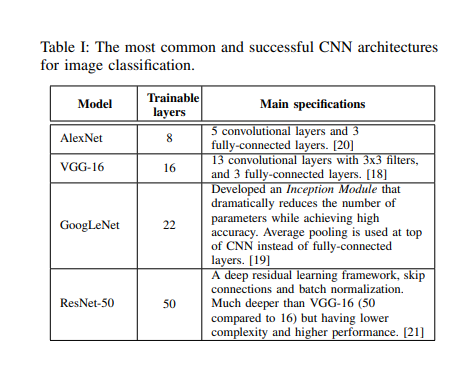

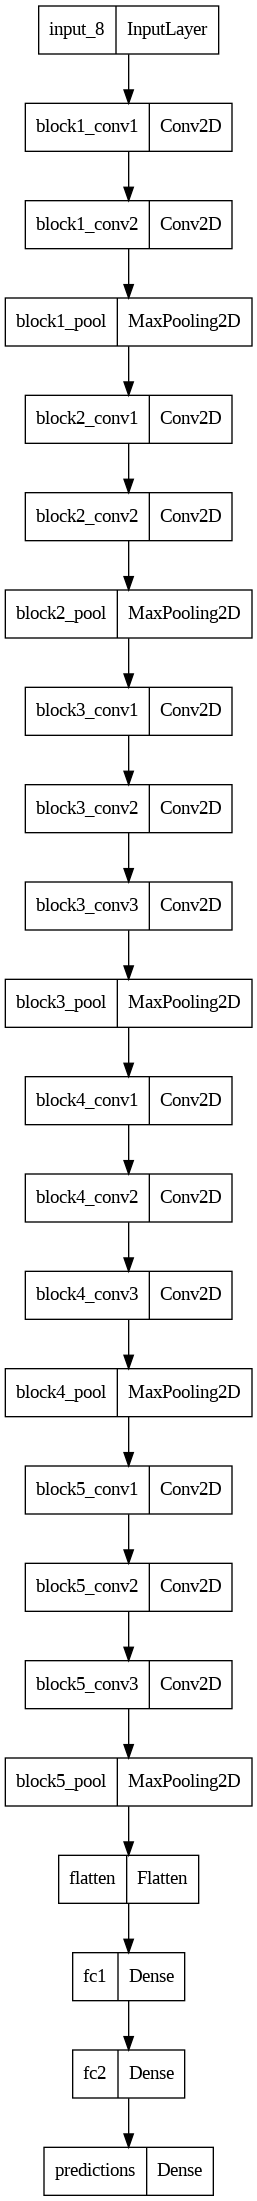

In [59]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model

# load the model
model = VGG16()
plot_model(model)

In [60]:
from keras.preprocessing.image import load_img
# load an image from file
image = load_img('/content/Animals/images/cat/1012.jpeg', target_size=(224, 224))

In [61]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

In [62]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [63]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

In [64]:
# predict the probability across all output classes
yhat = model.predict(image)

1/1 [==============================] - 1s 761ms/step


In [65]:
from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

Egyptian_cat (81.23%)


# 3.2 Wybrany model - MobileNetV3

https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

In [66]:
# nie wszystkie potrzebne
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

In [67]:
mobile = keras.applications.mobilenet.MobileNet()
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [68]:
preprocessed_image = prepare_image('/content/Animals/images/cat/100.jpeg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 1s 549ms/step


[[('n02124075', 'Egyptian_cat', 0.77930963),
  ('n02123045', 'tabby', 0.20108724),
  ('n02123159', 'tiger_cat', 0.018129412),
  ('n02127052', 'lynx', 0.00081075146),
  ('n02119789', 'kit_fox', 0.00013540892)]]